<a href="https://colab.research.google.com/github/Joefamouze/hello-world/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install --upgrade tensorflow_hub


  model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
  embeddings = model(["The rain in Spain.", "falls",
                      "mainly", "In the plain!"])

  print(embeddings.shape)  #(4,128)

In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
# Download the classifier URL
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

16384/10484 [==============================================] - 0s 0us/step


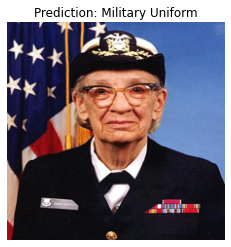

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
# exercise with flowers using transfer learning

In [54]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [55]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [56]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))


Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [63]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [64]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [65]:
feature_extractor.trainable = False

In [66]:
model = tf.keras.Sequential([
            feature_extractor,
            layers.Dense(num_classes)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5010      
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 6

history = model.fit(
    train_batches,
    epochs = EPOCHS,
    validation_data = validation_batches
)

Epoch 1/6
81/81 [==============================] - 8s 58ms/step - loss: 1.1421 - accuracy: 0.5843 - val_loss: 0.4080 - val_accuracy: 0.8565
Epoch 2/6
81/81 [==============================] - 4s 47ms/step - loss: 0.3452 - accuracy: 0.8779 - val_loss: 0.3809 - val_accuracy: 0.8610
Epoch 3/6
81/81 [==============================] - 4s 47ms/step - loss: 0.2861 - accuracy: 0.9106 - val_loss: 0.3441 - val_accuracy: 0.8837
Epoch 4/6
81/81 [==============================] - 4s 48ms/step - loss: 0.2348 - accuracy: 0.9216 - val_loss: 0.3422 - val_accuracy: 0.8883
Epoch 5/6
81/81 [==============================] - 4s 48ms/step - loss: 0.2049 - accuracy: 0.9347 - val_loss: 0.3358 - val_accuracy: 0.8865
Epoch 6/6
81/81 [==============================] - 4s 48ms/step - loss: 0.1776 - accuracy: 0.9518 - val_loss: 0.3408 - val_accuracy: 0.8837


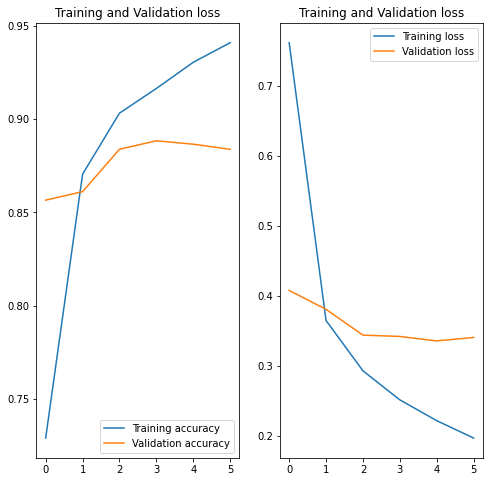

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation loss')
plt.show()

In [75]:
class_name = np.array(dataset_info.features['label'].names)
print(class_name)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [76]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_name[predicted_ids]

print(predicted_class_names)

['sunflowers' 'daisy' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'sunflowers' 'tulips' 'daisy' 'dandelion'
 'dandelion' 'daisy' 'dandelion' 'dandelion' 'dandelion' 'daisy'
 'dandelion' 'daisy' 'sunflowers' 'tulips' 'dandelion' 'daisy' 'roses'
 'dandelion' 'daisy' 'tulips' 'sunflowers' 'roses' 'dandelion' 'dandelion']


In [77]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [3 1 0 0 0 0 2 3 3 0 1 0 0 1 0 0 0 2 0 1 3 2 0 1 4 0 1 2 3 4 0 0]
Predicted labels:  [3 1 0 0 0 0 2 3 3 2 1 0 0 1 0 0 0 1 0 1 3 2 0 1 4 0 1 2 3 4 0 0]


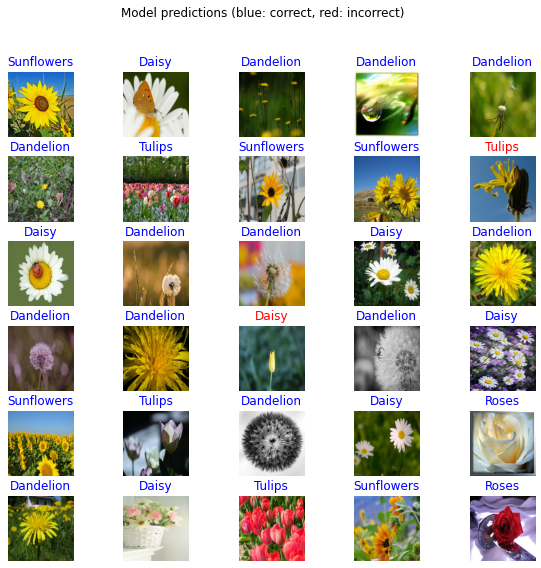

In [78]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [80]:
#inception model for transfer learning
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised = True,
    split = ['train[:70%]', 'train[70%:]']
)

IMAGE_RES = 299

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [81]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 23s 213ms/step - loss: 1.0604 - accuracy: 0.5836 - val_loss: 0.4483 - val_accuracy: 0.8538
Epoch 2/6
81/81 [==============================] - 15s 183ms/step - loss: 0.4007 - accuracy: 0.8774 - val_loss: 0.3794 - val_accuracy: 0.8783
Epoch 3/6
81/81 [==============================] - 14s 177ms/step - loss: 0.3231 - accuracy: 0.9033 - val_loss: 0.3207 - val_accuracy: 0.8883
Epoch 4/6
81/81 [==============================] - 14s 174ms/step - loss: 0.2624 - accuracy: 0.9173 - val_loss: 0.3186 - val_accuracy: 0.8883
Epoch 5/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2511 - accuracy: 0.9307 - val_loss: 0.2941 - val_accuracy: 0.8946
Epoch 6/6
81/81 [==============================] - 14s 177ms/step - loss: 0.2079 - accuracy: 0.9423 - val_loss: 0.2892 - val_accuracy: 0.8983
